In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17529932250549843308
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5032735333979885895
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import cv2
from tqdm import tqdm
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.preprocessing.image import  ImageDataGenerator as IDG


np.random.seed(1234)

Using TensorFlow backend.


In [0]:
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip"
!unzip -qq GTSRB-Training_fixed.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"
!unzip -qq GTSRB_Final_Test_GT.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
!unzip -qq GTSRB_Final_Test_Images.zip

--2020-05-24 09:33:50--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187490228 (179M) [application/zip]
Saving to: ‘GTSRB-Training_fixed.zip’

GTSRB-Training_fixe 100%[===================>] 178.80M  10.7MB/s    in 19s     

2020-05-24 09:34:10 (9.51 MB/s) - ‘GTSRB-Training_fixed.zip’ saved [187490228/187490228]

--2020-05-24 09:34:19--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   175KB/s    in 0.6s    

202

In [0]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def TSreadTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Final_Tets/images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    with open('/content/GT-final_test.csv') as gtFile:# annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(rootpath + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
    return images, labels


In [0]:
tr_images , tr_labels = readTrafficSigns('./GTSRB/Training')
ts_images , ts_labels = TSreadTrafficSigns('./GTSRB/Final_Test/Images/')

# make all the images have size(30, 30)
for i , img in enumerate(tr_images):
    tr_images[i] = cv2.resize(img , (30,30))

for i, img in enumerate(ts_images):
    ts_images[i] = cv2.resize(img, (30,30))

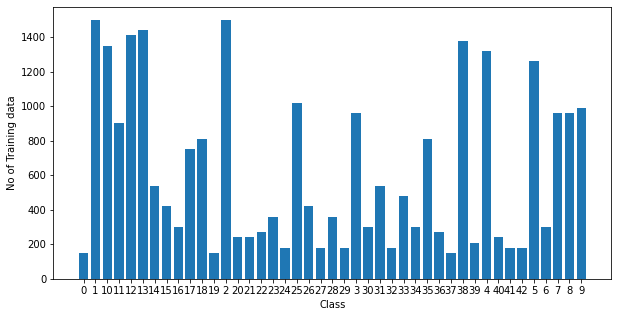

In [0]:
unique_elements, counts_elements = np.unique(sorted(tr_labels), return_counts = True)
plt.figure(figsize=(10 , 5))
plt.bar(unique_elements , counts_elements)
plt.xlabel('Class')
plt.ylabel('No of Training data')

mx_count = max(counts_elements)

In [0]:
# standard data
tr_images = np.array(tr_images,dtype=np.float32)/255.0
ts_images = np.array(ts_images,dtype=np.float32)/255.0
tr_labels = keras.utils.to_categorical(tr_labels)
ts_labels = keras.utils.to_categorical(ts_labels)

In [0]:
n_classes = 43
def create_model(activation_function):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (3, 3), activation = activation_function , input_shape = (30, 30, 3))) # 28x28x32
  model.add(MaxPooling2D(pool_size = (2, 2))) # 14x14x32
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size = (3, 3), activation = activation_function)) # 12x12x64
  model.add(MaxPooling2D(pool_size = (2, 2))) # 6x6x64
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size = (3, 3), activation = activation_function)) #4x4x128
  model.add(MaxPooling2D(pool_size = (2, 2))) #2x2x128
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(128, activation = activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation = 'softmax'))
  return model

In [0]:
model = create_model('relu')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
learned_model = model.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 20)

Train on 26640 samples, validate on 12630 samples
Epoch 1/20
26640/26640 [==============================] - 58s 2ms/step - loss: 3.0760 - accuracy: 0.2087 - val_loss: 4.0684 - val_accuracy: 0.0356
Epoch 2/20
26640/26640 [==============================] - 58s 2ms/step - loss: 1.6512 - accuracy: 0.4899 - val_loss: 4.4504 - val_accuracy: 0.1211
Epoch 3/20
26640/26640 [==============================] - 58s 2ms/step - loss: 1.0263 - accuracy: 0.6652 - val_loss: 1.2246 - val_accuracy: 0.6576
Epoch 4/20
26640/26640 [==============================] - 57s 2ms/step - loss: 0.7029 - accuracy: 0.7697 - val_loss: 0.4682 - val_accuracy: 0.8654
Epoch 5/20
26640/26640 [==============================] - 57s 2ms/step - loss: 0.5309 - accuracy: 0.8270 - val_loss: 0.3612 - val_accuracy: 0.8942
Epoch 6/20
26640/26640 [==============================] - 57s 2ms/step - loss: 0.4306 - accuracy: 0.8628 - val_loss: 0.2768 - val_accuracy: 0.9208
Epoch 7/20
26640/26640 [==============================] - 58s 2ms/st

In [0]:
model.trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
def calculate_classes_mean(ts_labels, dataset, class_number):
  # print(dataset)
  labels = np.eye(n_classes)
  # print("defined labels is: ", labels)
  boolean_form = np.zeros((class_number, ts_labels.shape[0]), dtype=bool)
  # print(boolean_form)
  for i in range(len(labels)):
      difference = np.linalg.norm(ts_labels - labels[i], axis=1)
      # if difference == 0:
      boolean_form[i] = (difference == 0)
  # print(boolean_form)
  # for i in range(len(boolean_form)):
  #   if boolean_form == True:
  #     print(i)

  classes_mean = np.zeros((class_number, dataset.shape[1]))
  for i in range(class_number):
        classes_mean[i] = np.mean(dataset[boolean_form[i]], axis=0)
  # print(classes_mean)
  return classes_mean


In [0]:
def calculate_single_seperated_index(layer, ts_labels, class_number):
    one_deminsion = tf.reshape(layer, (layer.shape[0], -1))
    # calculate classes mean
    classes_mean = calculate_classes_mean(ts_labels, one_deminsion, class_number)
    counter = 0
    for i in range(layer.shape[0]):
        j = keras.backend.eval(tf.math.argmin(tf.norm(classes_mean - one_deminsion[i] , axis=1)))
        if ts_labels[i][j] == 1:
            counter += 1
    seperated_index = counter / layer.shape[0]
    return seperated_index

In [0]:
def make_seperated_index(ts_images, ts_labels, model):
  seperated_indexes = []
  tf_image_form = tf.convert_to_tensor(ts_images)
  for i in range(len(model.layers)):
    if i == 0:
      seperated_indexes.append(calculate_single_seperated_index(keras.backend.eval(tf_image_form), ts_labels, 43))
    print("new layer")
    tf_image_form = model.layers[i](tf_image_form)
    seperated_indexes.append(calculate_single_seperated_index(keras.backend.eval(tf_image_form), ts_labels, 43))
    print("for layer ", i, "seperated index is ", seperated_indexes[i])
  return seperated_indexes

In [131]:
seperated_indexes = make_seperated_index(ts_images, ts_labels, model)

new layer
for layer  0 seperated index is  0.22399049881235156
new layer
for layer  1 seperated index is  0.331353919239905
new layer
for layer  2 seperated index is  0.3418844022169438
new layer
for layer  3 seperated index is  0.5185273159144893
new layer
for layer  4 seperated index is  0.766270783847981
new layer
for layer  5 seperated index is  0.7814726840855107
new layer
for layer  6 seperated index is  0.7814726840855107
new layer
for layer  7 seperated index is  0.8346001583531275
new layer
for layer  8 seperated index is  0.8749802058590657
new layer
for layer  9 seperated index is  0.8850356294536817
new layer
for layer  10 seperated index is  0.8850356294536817
new layer
for layer  11 seperated index is  0.8850356294536817
new layer
for layer  12 seperated index is  0.8841646872525732
new layer
for layer  13 seperated index is  0.8830562153602534
new layer
for layer  14 seperated index is  0.8830562153602534


Text(0, 0.5, 'seperated index')

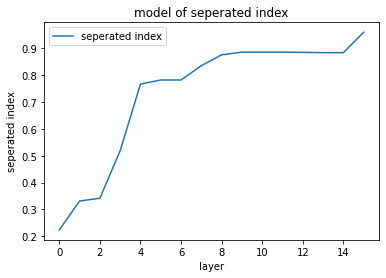

In [133]:
plt.plot(range(0, 16) , seperated_indexes)
plt.title('model of seperated index')
plt.legend(['seperated index'])
plt.xlabel('layer')
plt.ylabel('seperated index')
